1. Setup and imports

In [1]:
import sys, importlib
from pathlib import Path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pythermalcomfort.utilities import wet_bulb_tmp

ROOT = Path().resolve().parent
sys.path.append(str(ROOT))

In [2]:
# libs do projeto 
import src.climate_baselines as cb
import src.hw_detect_inmet as hw_inmet
import src.hw_detect_ouzeau as hw_ouzeau
import src.events_utils as evu

In [3]:
import src.hw_detect_wetbulb as hw_tw
importlib.reload(hw_tw)

<module 'src.hw_detect_wetbulb' from 'G:\\Meu Drive\\UFSC\\UFSC - Doutorado\\3 HW Detection methods\\1 Desenvolvimento - Pipeline\\src\\hw_detect_wetbulb.py'>

In [4]:
import importlib
from src.events_metrics import Thresholds, compute_event_metrics, expand_event_metrics_to_timeseries
import src.events_metrics as em
importlib.reload(em)

<module 'src.events_metrics' from 'G:\\Meu Drive\\UFSC\\UFSC - Doutorado\\3 HW Detection methods\\1 Desenvolvimento - Pipeline\\src\\events_metrics.py'>

In [5]:
importlib.reload(cb); importlib.reload(hw_inmet); importlib.reload(hw_ouzeau); importlib.reload(evu)

<module 'src.events_utils' from 'G:\\Meu Drive\\UFSC\\UFSC - Doutorado\\3 HW Detection methods\\1 Desenvolvimento - Pipeline\\src\\events_utils.py'>

2. Site parameters and path

In [6]:
SITE_ID = "MAO" 
INTERIM_DIR = ROOT / "data" / "interim" / SITE_ID
PROC_DIR = ROOT / "data" / "processed" / SITE_ID
PROC_DIR.mkdir(parents=True, exist_ok=True)

# Baseline climatológica (fixa) para comparabilidade
BASELINE = ("1991-01-01", "2020-12-31")

RAW_CSV = INTERIM_DIR / "met_raw.csv.gz"   # gerado no 0_ingest_epw.ipynb
DAILY_CSV = INTERIM_DIR / "met_daily.csv.gz"  # opcional; recalculamos abaixo mesmo se não existir

3. Load the datasets

In [7]:
# Série completa com TODAS as variáveis (UTC naive em timeset)
df = pd.read_csv(RAW_CSV, parse_dates=["timeset"])
df = df.sort_values("timeset").reset_index(drop=True)
df["site_id"] = df["site_id"].astype("string")

# séries diárias a partir do raw (Tmax e T̄ de Ta)
daily = (df.set_index("timeset")
           .resample("D")
           .agg(tmax_c=("ta_c", "max"),
                tmean_c=("ta_c", "mean"))
           .reset_index())
daily["site_id"] = SITE_ID

display(df.head(3))
display(daily.head(3))

,site_id,timeset,year,month,day,hour,ta_c,tdp_c,rh_pct,p_atm_pa,...,latitude,longitude,elevation_m,scenario_category,scenario_horizon,scenario_rcp,period_start,period_end,epw_tz_offset_h,epw_tz_label
0,MAO,1991-01-01 01:00:00,1991,1,1,1,23.0,23.0,100,100389,...,-3.039,-60.05,80.5,historical,NaN,NaN,1991,2023,-4.0,UTC-4
1,MAO,1991-01-01 02:00:00,1991,1,1,2,23.0,23.0,100,100389,...,-3.039,-60.05,80.5,historical,NaN,NaN,1991,2023,-4.0,UTC-4
2,MAO,1991-01-01 03:00:00,1991,1,1,3,23.0,23.0,100,100389,...,-3.039,-60.05,80.5,historical,NaN,NaN,1991,2023,-4.0,UTC-4


,timeset,tmax_c,tmean_c,site_id
0,1991-01-01,30.0,25.391304,MAO
1,1991-01-02,34.0,26.916667,MAO
2,1991-01-03,35.0,28.250000,MAO


In [8]:
# adicionar wet bulb temperature 
# segurança: RH em [0, 100] e evitar 0
df["rh_pct_clip"] = df["rh_pct"].clip(lower=0.1, upper=100)

# Tw horário (°C)
df["tw_c"] = wet_bulb_tmp(tdb=df["ta_c"].to_numpy(),
                          rh=df["rh_pct_clip"].to_numpy())

df["tw_c"] = np.minimum(df["tw_c"], df["ta_c"])

In [9]:
df[["timeset","ta_c","rh_pct","tw_c"]].head(5)


,timeset,ta_c,rh_pct,tw_c
0,1991-01-01 01:00:00,23.0,100,23.0
1,1991-01-01 02:00:00,23.0,100,23.0
2,1991-01-01 03:00:00,23.0,100,23.0
3,1991-01-01 04:00:00,23.0,100,23.0
4,1991-01-01 05:00:00,23.0,100,23.0


In [10]:
# sanity check: Tw não deveria ser maior que Tdb (na prática quase sempre Tw <= Tdb)
(df["tw_c"] > df["ta_c"]).mean()

np.float64(0.0)

In [11]:
daily_tw = (df.set_index("timeset")
              .resample("D")
              .agg(twmax_c=("tw_c", "max"),
                   twmean_c=("tw_c", "mean"))
              .reset_index())

daily = daily.merge(daily_tw, on="timeset", how="left")
daily["site_id"] = SITE_ID

In [12]:
daily.head(3)

,timeset,tmax_c,tmean_c,site_id,twmax_c,twmean_c
0,1991-01-01,30.0,25.391304,MAO,27.729966,24.147951
1,1991-01-02,34.0,26.916667,MAO,29.489904,24.911114
2,1991-01-03,35.0,28.250000,MAO,29.207100,25.542279


4. Climatological normals (INMET) and thresholds (Ouzeau)

In [13]:
# Normais mensais de Tmax (INMET/WMO) na baseline
daily_max = daily[["timeset", "tmax_c"]].dropna()
normals_m = cb.monthly_normals_tmax(daily_max.rename(columns={"tmax_c": "tmax_c"}),
                                    baseline=BASELINE)

# Percentis Ouzeau de T̄ diária (baseline)
daily_mean = daily[["timeset", "tmean_c"]].dropna()
ouz_thr = cb.ouzeau_thresholds_tmean(daily_mean, baseline=BASELINE)

normals_m, ouz_thr


(    month  normal_tmax_c
 0       1      30.804161
 1       2      30.667276
 2       3      30.732172
 3       4      30.752733
 4       5      30.953032
 5       6      31.564644
 6       7      32.137000
 7       8      33.159699
 8       9      33.523800
 9      10      33.182656
 10     11      32.501456
 11     12      31.316903,
 {'spic': np.float64(30.708333333333332),
  'sdeb': np.float64(29.708333333333332),
  'sint': np.float64(29.208333333333332)})

In [14]:
# Percentil global p90 da Tw média diária (baseline)
daily_twmean = daily[["timeset", "twmean_c"]].dropna()

tw_p90 = (
    daily_twmean[
        (daily_twmean["timeset"] >= BASELINE[0]) &
        (daily_twmean["timeset"] <= BASELINE[1])
    ]["twmean_c"]
    .quantile(0.90)
)

tw_p90

np.float64(25.85402430446886)

5. Events detection (INMET)

In [15]:
# Detecta eventos INMET (>= 2 dias acima da normal mensal + Δ=5°C)
events_inmet, inmet_flags_daily = hw_inmet.detect_inmet_events(
    daily_max_df=daily_max.rename(columns={"tmax_c":"tmax_c"}),
    normals_m=normals_m,
    site_id=SITE_ID,
    delta=5.0,
)

In [16]:
# Padroniza, anexa metadados e IDs
ev_inmet_std = evu.standardize_events(
    events_inmet,
    site_id=SITE_ID,
    method="INMET",
    method_version="INMET-1.0",
    baseline=BASELINE,
    threshold_info={"delta_c": 5.0, "normals": "1991-2020"},
    add_level_by_duration=True,   # define nível Yellow/Orange/Red por duração
)
ev_inmet_std = evu.attach_event_id(ev_inmet_std, site_id=SITE_ID, method="INMET")

display(ev_inmet_std)

,start,end,duration_d,peak_c,method,site_id,level,method_version,baseline_start,baseline_end,threshold_info,hw_id
0,1992-02-01,1992-02-02,2,36.0,INMET,MAO,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",MAO-INMET-19920201-001
1,2016-01-10,2016-01-11,2,36.0,INMET,MAO,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",MAO-INMET-20160110-001
2,2016-01-17,2016-01-18,2,37.0,INMET,MAO,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",MAO-INMET-20160117-002


6. Events detection (Ouzeau)

In [17]:
# Detecta eventos Ouzeau (Spic/Sdeb/Sint sobre T̄ diária)
events_ouz, ouz_flags_daily = hw_ouzeau.detect_ouzeau_events(
    daily_mean_df=daily_mean.rename(columns={"tmean_c":"tmean_c"}),
    thresholds=ouz_thr,
    site_id=SITE_ID,
    n_consecutive=3,  # ajuste se quiser 5
)


In [18]:
# Padroniza e IDs
ev_ouz_std = evu.standardize_events(
    events_ouz,
    site_id=SITE_ID,
    method="Ouzeau",
    method_version="OUZ-2016-v1",
    baseline=BASELINE,
    threshold_info={"spic": float(ouz_thr["spic"]),
                    "sdeb": float(ouz_thr["sdeb"]),
                    "sint": float(ouz_thr["sint"]),
                    "baseline": "1991-2020"},
    add_level_by_duration=False,  # nível é opcional no Ouzeau; se quiser, mude para True
)
ev_ouz_std = evu.attach_event_id(ev_ouz_std, site_id=SITE_ID, method="Ouzeau")

display(ev_ouz_std)

,start,end,duration_d,peak_c,method,site_id,method_version,baseline_start,baseline_end,threshold_info,level,hw_id
0,1997-09-11,1997-09-28,18,31.020833,Ouzeau,MAO,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",,MAO-Ouzeau-19970911-001
1,1997-09-30,1997-10-05,6,30.875000,Ouzeau,MAO,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",,MAO-Ouzeau-19970930-002
2,1997-10-12,1997-10-19,8,31.895833,Ouzeau,MAO,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",,MAO-Ouzeau-19971012-003
3,1997-10-21,1997-10-22,2,30.750000,Ouzeau,MAO,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",,MAO-Ouzeau-19971021-004
4,1997-10-25,1997-11-02,9,32.187500,Ouzeau,MAO,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",,MAO-Ouzeau-19971025-005
5,1998-10-06,1998-10-10,5,31.041667,Ouzeau,MAO,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",,MAO-Ouzeau-19981006-001
6,2002-10-08,2002-10-13,6,30.750000,Ouzeau,MAO,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",,MAO-Ouzeau-20021008-001
7,2009-10-06,2009-10-09,4,30.750000,Ouzeau,MAO,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",,MAO-Ouzeau-20091006-001
8,2010-09-29,2010-10-01,3,30.708333,Ouzeau,MAO,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",,MAO-Ouzeau-20100929-001
9,2010-10-30,2010-11-01,3,30.791667,Ouzeau,MAO,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",,MAO-Ouzeau-20101030-002


6. Events detection (Tw)

In [19]:
events_tw, tw_flags_daily = hw_tw.detect_wetbulb_p90_events(
    daily_tw_df=daily_twmean,
    tw_p90=float(tw_p90),
    site_id=SITE_ID,
    n_consecutive=3,
    value_col="twmean_c",
)

In [20]:
ev_tw_std = evu.standardize_events(
    events_tw,
    site_id=SITE_ID,
    method="TW_P90",
    method_version="TW-P90-v1",
    baseline=BASELINE,
    threshold_info={
        "tw_p90": float(tw_p90),
        "tw_col": "twmean_c",
        "baseline": "1991-2020",
        "n_consecutive": 3,
    },
    add_level_by_duration=False, 
)

ev_tw_std = evu.attach_event_id(ev_tw_std, site_id=SITE_ID, method="TW_P90")

display(ev_tw_std)

,start,end,duration_d,peak_c,method,site_id,method_version,baseline_start,baseline_end,threshold_info,level,hw_id
0,1991-05-29,1991-06-01,4,26.760946,TW_P90,MAO,TW-P90-v1,1991-01-01,2020-12-31,"{'tw_p90': 25.85402430446886, 'tw_col': 'twmea...",,MAO-TW_P90-19910529-001
1,1991-09-16,1991-09-19,4,26.929951,TW_P90,MAO,TW-P90-v1,1991-01-01,2020-12-31,"{'tw_p90': 25.85402430446886, 'tw_col': 'twmea...",,MAO-TW_P90-19910916-002
2,1991-09-28,1991-10-01,4,26.465631,TW_P90,MAO,TW-P90-v1,1991-01-01,2020-12-31,"{'tw_p90': 25.85402430446886, 'tw_col': 'twmea...",,MAO-TW_P90-19910928-003
3,1991-12-09,1991-12-11,3,26.721899,TW_P90,MAO,TW-P90-v1,1991-01-01,2020-12-31,"{'tw_p90': 25.85402430446886, 'tw_col': 'twmea...",,MAO-TW_P90-19911209-004
4,1992-02-01,1992-02-08,8,27.401742,TW_P90,MAO,TW-P90-v1,1991-01-01,2020-12-31,"{'tw_p90': 25.85402430446886, 'tw_col': 'twmea...",,MAO-TW_P90-19920201-001
...,...,...,...,...,...,...,...,...,...,...,...,...
113,2004-11-11,2004-11-13,3,26.658529,TW_P90,MAO,TW-P90-v1,1991-01-01,2020-12-31,"{'tw_p90': 25.85402430446886, 'tw_col': 'twmea...",,MAO-TW_P90-20041111-001
114,2004-11-18,2004-11-21,4,26.581482,TW_P90,MAO,TW-P90-v1,1991-01-01,2020-12-31,"{'tw_p90': 25.85402430446886, 'tw_col': 'twmea...",,MAO-TW_P90-20041118-002
115,2005-10-29,2005-11-01,4,26.800109,TW_P90,MAO,TW-P90-v1,1991-01-01,2020-12-31,"{'tw_p90': 25.85402430446886, 'tw_col': 'twmea...",,MAO-TW_P90-20051029-001
116,2008-02-08,2008-02-10,3,26.164756,TW_P90,MAO,TW-P90-v1,1991-01-01,2020-12-31,"{'tw_p90': 25.85402430446886, 'tw_col': 'twmea...",,MAO-TW_P90-20080208-001


7. Events consolidations and CSV outputs

In [21]:
events_all = pd.concat([ev_inmet_std, ev_ouz_std, ev_tw_std], ignore_index=True)
events_all = events_all.sort_values(["method","start"]).reset_index(drop=True)

# Salvar eventos por método + consolidado
ev_inmet_std.to_csv(PROC_DIR / "events_inmet.csv", index=False)
ev_ouz_std.to_csv(PROC_DIR / "events_ouzeau.csv", index=False)
ev_tw_std.to_csv(PROC_DIR / "events_tw_p90.csv", index=False)

events_all.to_csv(PROC_DIR / "events_all.csv", index=False)

events_all.head(10)

,start,end,duration_d,peak_c,method,site_id,level,method_version,baseline_start,baseline_end,threshold_info,hw_id
0,1992-02-01,1992-02-02,2,36.000000,INMET,MAO,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",MAO-INMET-19920201-001
1,2016-01-10,2016-01-11,2,36.000000,INMET,MAO,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",MAO-INMET-20160110-001
2,2016-01-17,2016-01-18,2,37.000000,INMET,MAO,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",MAO-INMET-20160117-002
3,1997-09-11,1997-09-28,18,31.020833,Ouzeau,MAO,,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",MAO-Ouzeau-19970911-001
4,1997-09-30,1997-10-05,6,30.875000,Ouzeau,MAO,,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",MAO-Ouzeau-19970930-002
5,1997-10-12,1997-10-19,8,31.895833,Ouzeau,MAO,,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",MAO-Ouzeau-19971012-003
6,1997-10-21,1997-10-22,2,30.750000,Ouzeau,MAO,,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",MAO-Ouzeau-19971021-004
7,1997-10-25,1997-11-02,9,32.187500,Ouzeau,MAO,,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",MAO-Ouzeau-19971025-005
8,1998-10-06,1998-10-10,5,31.041667,Ouzeau,MAO,,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",MAO-Ouzeau-19981006-001
9,2002-10-08,2002-10-13,6,30.750000,Ouzeau,MAO,,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 30.708333333333332, 'sdeb': 29.708333...",MAO-Ouzeau-20021008-001


8. Full dataframe with flags

In [22]:
timeline = df[["timeset"]].copy()
flags_inmet = evu.flags_from_events(events_all, timeline, method="INMET",  col_name="HW_INMET_bool")
flags_ouz   = evu.flags_from_events(events_all, timeline, method="Ouzeau", col_name="HW_OU_bool")
flags_tw    = evu.flags_from_events(events_all, timeline, method="TW_P90", col_name="HW_TW_bool")

df_flags = (
    timeline
    .merge(flags_inmet, on="timeset", how="left")
    .merge(flags_ouz,   on="timeset", how="left")
    .merge(flags_tw,    on="timeset", how="left")
    .fillna(False)
)

full_df = df.merge(df_flags, on="timeset", how="left")

full_df["HW_INMET_bool"] = full_df["HW_INMET_bool"].fillna(False)
full_df["HW_OU_bool"]    = full_df["HW_OU_bool"].fillna(False)
full_df["HW_TW_bool"]    = full_df["HW_TW_bool"].fillna(False)

full_df["HW_any_bool"]   = (
    full_df["HW_INMET_bool"] |
    full_df["HW_OU_bool"] |
    full_df["HW_TW_bool"]
)

display(full_df.head(3))

,site_id,timeset,year,month,day,hour,ta_c,tdp_c,rh_pct,p_atm_pa,...,period_start,period_end,epw_tz_offset_h,epw_tz_label,rh_pct_clip,tw_c,HW_INMET_bool,HW_OU_bool,HW_TW_bool,HW_any_bool
0,MAO,1991-01-01 01:00:00,1991,1,1,1,23.0,23.0,100,100389,...,1991,2023,-4.0,UTC-4,100,23.0,False,False,False,False
1,MAO,1991-01-01 02:00:00,1991,1,1,2,23.0,23.0,100,100389,...,1991,2023,-4.0,UTC-4,100,23.0,False,False,False,False
2,MAO,1991-01-01 03:00:00,1991,1,1,3,23.0,23.0,100,100389,...,1991,2023,-4.0,UTC-4,100,23.0,False,False,False,False


9. Full dataframe CSV export

In [23]:
out_csv = PROC_DIR / "full_timeseries_with_flags.csv.gz"
full_df.to_csv(
    out_csv,
    index=False,
    compression="gzip",
    date_format="%Y-%m-%dT%H:%M:%S",
    float_format="%.6g",
)
out_csv

WindowsPath('G:/Meu Drive/UFSC/UFSC - Doutorado/3 HW Detection methods/1 Desenvolvimento - Pipeline/data/processed/MAO/full_timeseries_with_flags.csv.gz')

10. Quality control

In [24]:
print("Período:", full_df["timeset"].min(), "→", full_df["timeset"].max())
print("Horário total:", len(full_df))

print("\nCobertura de eventos:")
print("INMET: ", full_df["HW_INMET_bool"].mean().round(4), "da série")
print("Ouzeau:", full_df["HW_OU_bool"].mean().round(4), "da série")
print("TW_P90:", full_df["HW_TW_bool"].mean().round(4), "da série")
print("ANY:   ", full_df["HW_any_bool"].mean().round(4), "da série")

# Conferir algumas janelas com evento (pega 1 evento por método, se existir)
for m, cols in [
    ("INMET",  ["timeset","ta_c","tw_c","HW_INMET_bool","HW_OU_bool","HW_TW_bool"]),
    ("Ouzeau", ["timeset","ta_c","tw_c","HW_INMET_bool","HW_OU_bool","HW_TW_bool"]),
    ("TW_P90", ["timeset","ta_c","tw_c","HW_INMET_bool","HW_OU_bool","HW_TW_bool"]),
]:
    ev_m = events_all.loc[events_all["method"] == m]
    if ev_m.empty:
        print(f"\nSem eventos para {m}.")
        continue

    some_evt = ev_m.sort_values("start").head(1).iloc[0]
    mask = (full_df["timeset"] >= some_evt["start"]) & (full_df["timeset"] <= some_evt["end"])
    print(f"\nJanela exemplo ({m}): {some_evt['start']} → {some_evt['end']} ({some_evt['duration_d']} d)")
    display(full_df.loc[mask, cols].head(10))


Período: 1991-01-01 01:00:00 → 2024-01-01 00:00:00
Horário total: 289272

Cobertura de eventos:
INMET:  0.0003 da série
Ouzeau: 0.0139 da série
TW_P90: 0.041 da série
ANY:    0.0514 da série

Janela exemplo (INMET): 1992-02-01 00:00:00 → 1992-02-02 00:00:00 (2 d)


,timeset,ta_c,tw_c,HW_INMET_bool,HW_OU_bool,HW_TW_bool
9503,1992-02-01 00:00:00,26.0,26.000000,True,False,True
9504,1992-02-01 01:00:00,26.0,26.000000,True,False,True
9505,1992-02-01 02:00:00,26.0,26.000000,True,False,True
9506,1992-02-01 03:00:00,25.0,25.000000,True,False,True
9507,1992-02-01 04:00:00,25.0,25.000000,True,False,True
9508,1992-02-01 05:00:00,25.0,25.000000,True,False,True
9509,1992-02-01 06:00:00,25.0,25.000000,True,False,True
9510,1992-02-01 07:00:00,25.0,25.000000,True,False,True
9511,1992-02-01 08:00:00,24.0,24.000000,True,False,True
9512,1992-02-01 09:00:00,28.0,25.789175,True,False,True



Janela exemplo (Ouzeau): 1997-09-11 00:00:00 → 1997-09-28 00:00:00 (18 d)


,timeset,ta_c,tw_c,HW_INMET_bool,HW_OU_bool,HW_TW_bool
58679,1997-09-11 00:00:00,27.0,26.224472,False,True,True
58680,1997-09-11 01:00:00,26.5,26.142310,False,True,True
58681,1997-09-11 02:00:00,25.5,25.500000,False,True,True
58682,1997-09-11 03:00:00,25.5,25.500000,False,True,True
58683,1997-09-11 04:00:00,25.5,25.500000,False,True,True
58684,1997-09-11 05:00:00,25.0,25.000000,False,True,True
58685,1997-09-11 06:00:00,25.0,25.000000,False,True,True
58686,1997-09-11 07:00:00,25.0,25.000000,False,True,True
58687,1997-09-11 08:00:00,25.0,25.000000,False,True,True
58688,1997-09-11 09:00:00,28.0,25.789175,False,True,True



Janela exemplo (TW_P90): 1991-05-29 00:00:00 → 1991-06-01 00:00:00 (4 d)


,timeset,ta_c,tw_c,HW_INMET_bool,HW_OU_bool,HW_TW_bool
3551,1991-05-29 00:00:00,25.0,25.000000,False,False,True
3552,1991-05-29 01:00:00,25.0,25.000000,False,False,True
3553,1991-05-29 02:00:00,24.0,24.000000,False,False,True
3554,1991-05-29 03:00:00,24.0,24.000000,False,False,True
3555,1991-05-29 04:00:00,24.0,24.000000,False,False,True
3556,1991-05-29 05:00:00,24.0,24.000000,False,False,True
3557,1991-05-29 06:00:00,24.0,24.000000,False,False,True
3558,1991-05-29 07:00:00,23.0,23.000000,False,False,True
3559,1991-05-29 08:00:00,25.0,24.236211,False,False,True
3560,1991-05-29 09:00:00,29.0,25.272376,False,False,True


11. Heatwave characterization

In [25]:
# Séries diárias já criadas no notebook:
dmax  = daily[["timeset","tmax_c"]].dropna().copy()
dmean = daily[["timeset","tmean_c"]].dropna().copy()
dtw   = daily[["timeset","twmean_c"]].dropna().copy()

# Thresholds
thr_inmet = Thresholds(method="INMET", normals_m=normals_m, delta_c=5.0)
thr_ouz   = Thresholds(method="Ouzeau", sdeb_c=float(ouz_thr["sdeb"]))
thr_tw    = Thresholds(method="TW_P90", tw_p90_c=float(tw_p90))

# Métricas por evento
ev_inmet_metrics  = compute_event_metrics(ev_inmet_std, dmean, dmax, thr_inmet)
ev_ouzeau_metrics = compute_event_metrics(ev_ouz_std,   dmean, dmax, thr_ouz)
ev_tw_metrics     = compute_event_metrics(ev_tw_std,    dmean, dmax, thr_tw, daily_twmean=dtw) 

# Propagar para série horária completa
full_plus = expand_event_metrics_to_timeseries(ev_inmet_metrics,  full_df, "INMET")
full_plus = expand_event_metrics_to_timeseries(ev_ouzeau_metrics, full_plus, "OUZ")
full_plus = expand_event_metrics_to_timeseries(ev_tw_metrics,     full_plus, "TW")   


In [26]:
# Salvar
PROC_DIR.mkdir(parents=True, exist_ok=True)

(pd.concat([ev_inmet_metrics, ev_ouzeau_metrics, ev_tw_metrics], ignore_index=True)
   .sort_values(["method","start"])
   .reset_index(drop=True)
   .to_csv(PROC_DIR / "events_all_with_metrics.csv", index=False))

full_plus.to_csv(PROC_DIR / "full_timeseries_with_flags_and_metrics.csv.gz",
                 index=False, compression="gzip",
                 date_format="%Y-%m-%dT%H:%M:%S", float_format="%.6g")

12. Novo quality control

C:\Users\Matheus\AppData\Local\Temp\ipykernel_8384\921815738.py:2: DtypeWarning: Columns (57,61,62,66,67,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE, parse_dates=["timeset"]).sort_values("timeset").reset_index(drop=True)


Período: 1991-01-01 01:00:00 → 2024-01-01 00:00:00
Total de registros: 289272
Gaps detectados (>1h): 0

Faixas físicas:
             ta_c: 18.00 → 39.00
             tw_c: 16.33 → 33.76
           rh_pct: 23.00 → 100.00
      wind_spd_ms: 0.00 → 26.80
         p_atm_pa: 100311.00 → 100437.00

Sanity (Tw > Ta): 0.000000 da série (esperado ~0 após clamp)

Cobertura de eventos (por hw_id):
  INMET : 0.05%
  OUZ   : 1.60%
  TW    : 5.04%

Cobertura de eventos (por flags):
  INMET : 0.03%
  OUZ   : 1.39%
  TW    : 4.10%
  ANY   : 5.14%

Consistência (hw_id vs flag):
  INMET: 0.999761
  OUZ  : 0.997853
  TW   : 0.990618

Resumo das métricas (linhas com pelo menos uma métrica não-nula):


,mean,std,min,50%,max
INMET_intensity_c,36.333333,0.473050,36.000000,36.000000,37.00000
INMET_duration_d,2.000000,0.000000,2.000000,2.000000,2.00000
INMET_severity_cday,0.816268,0.423422,0.391677,0.665448,1.39168
OUZ_intensity_c,37.487047,0.808776,36.000000,37.000000,39.00000
OUZ_duration_d,10.129534,5.578019,2.000000,9.000000,20.00000
OUZ_severity_cday,9.294356,8.557364,1.041670,6.333330,31.08330
TW_intensity_c,35.761960,1.522955,32.120000,36.000000,39.00000
TW_duration_d,7.800659,5.987958,3.000000,5.000000,27.00000
TW_severity_cday,4.949728,5.294088,0.312362,2.867750,20.45370


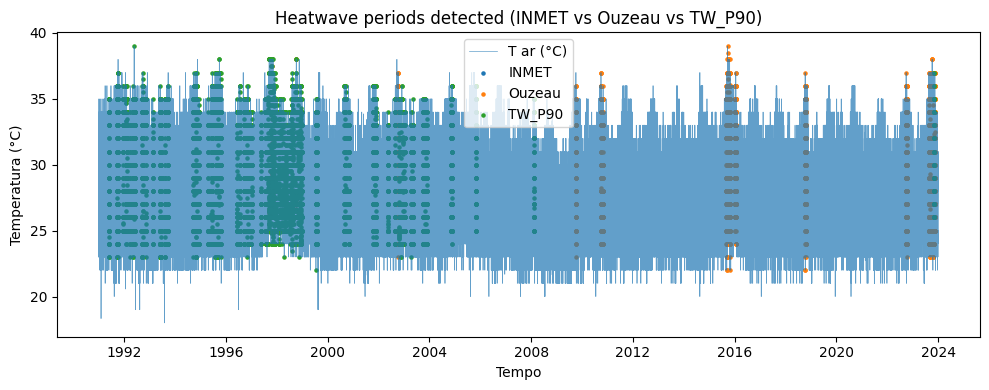

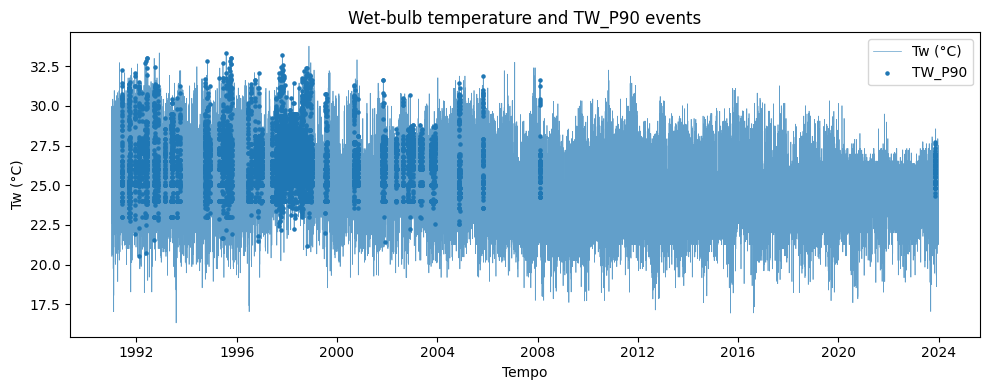

In [27]:
FILE = PROC_DIR / "full_timeseries_with_flags_and_metrics.csv.gz"
df = pd.read_csv(FILE, parse_dates=["timeset"]).sort_values("timeset").reset_index(drop=True)

print("Período:", df["timeset"].min(), "→", df["timeset"].max())
print("Total de registros:", len(df))

# === 1. Cobertura temporal (gaps) ===
df["gap_h"] = (df["timeset"] - df["timeset"].shift()).dt.total_seconds() / 3600
gaps = df[df["gap_h"] > 1]
print(f"Gaps detectados (>1h): {len(gaps)}")
if len(gaps) > 0:
    print("Maior gap (h):", float(gaps["gap_h"].max()))
    display(gaps[["timeset", "gap_h"]].head(10))

# === 2. Faixas físicas ===
qc_phys = {}
for col in ["ta_c", "tw_c", "rh_pct", "wind_spd_ms", "p_atm_pa"]:
    if col in df.columns:
        qc_phys[col] = (df[col].min(), df[col].max())

print("\nFaixas físicas:")
for k, (vmin, vmax) in qc_phys.items():
    try:
        print(f"  {k:>15}: {vmin:.2f} → {vmax:.2f}")
    except Exception:
        print(f"  {k:>15}: {vmin} → {vmax}")

# Sanity extra: Tw deveria ser <= Ta (após clamp)
if "tw_c" in df.columns and "ta_c" in df.columns:
    frac_tw_gt_ta = (df["tw_c"] > df["ta_c"]).mean()
    print(f"\nSanity (Tw > Ta): {frac_tw_gt_ta:.6f} da série (esperado ~0 após clamp)")

# === 3. Cobertura de eventos (por hw_id e por flags) ===
def _safe_notna_mean(col):
    return df[col].notna().mean() * 100 if col in df.columns else float("nan")

def _safe_bool_mean(col):
    return df[col].mean() * 100 if col in df.columns else float("nan")

cov_inmet_id = _safe_notna_mean("INMET_hw_id")
cov_ouz_id   = _safe_notna_mean("OUZ_hw_id")
cov_tw_id    = _safe_notna_mean("TW_hw_id")

cov_inmet_fl = _safe_bool_mean("HW_INMET_bool")
cov_ouz_fl   = _safe_bool_mean("HW_OU_bool")
cov_tw_fl    = _safe_bool_mean("HW_TW_bool")
cov_any_fl   = _safe_bool_mean("HW_any_bool")

print("\nCobertura de eventos (por hw_id):")
print(f"  INMET : {cov_inmet_id:.2f}%")
print(f"  OUZ   : {cov_ouz_id:.2f}%")
print(f"  TW    : {cov_tw_id:.2f}%")

print("\nCobertura de eventos (por flags):")
print(f"  INMET : {cov_inmet_fl:.2f}%")
print(f"  OUZ   : {cov_ouz_fl:.2f}%")
print(f"  TW    : {cov_tw_fl:.2f}%")
print(f"  ANY   : {cov_any_fl:.2f}%")

# === 3b. Consistência flags vs hw_id (deve ser ~1.0) ===
def _consistency(id_col, flag_col):
    if id_col in df.columns and flag_col in df.columns:
        return (df[id_col].notna() == df[flag_col].astype(bool)).mean()
    return float("nan")

print("\nConsistência (hw_id vs flag):")
print("  INMET:", round(_consistency("INMET_hw_id", "HW_INMET_bool"), 6))
print("  OUZ  :", round(_consistency("OUZ_hw_id",   "HW_OU_bool"), 6))
print("  TW   :", round(_consistency("TW_hw_id",    "HW_TW_bool"), 6))

# === 4. Estatísticas das métricas ===
metrics_cols = [
    "INMET_intensity_c", "INMET_duration_d", "INMET_severity_cday",
    "OUZ_intensity_c",   "OUZ_duration_d",   "OUZ_severity_cday",
    "TW_intensity_c",    "TW_duration_d",    "TW_severity_cday",
]
metrics_cols = [c for c in metrics_cols if c in df.columns]

print("\nResumo das métricas (linhas com pelo menos uma métrica não-nula):")
if metrics_cols:
    mask_metrics = df[metrics_cols].notna().any(axis=1)
    desc = df.loc[mask_metrics, metrics_cols].describe().T[["mean", "std", "min", "50%", "max"]]
    display(desc)
else:
    print("Nenhuma coluna de métrica encontrada. Verifique o prefixo/nomes das colunas.")

# === 5. Visualização rápida (Ta + marcações por método) ===
plt.figure(figsize=(10, 4))
plt.plot(df["timeset"], df["ta_c"], lw=0.5, alpha=0.7, label="T ar (°C)")

if "INMET_hw_id" in df.columns:
    m = df["INMET_hw_id"].notna()
    plt.scatter(df.loc[m, "timeset"], df.loc[m, "ta_c"], s=5, label="INMET")

if "OUZ_hw_id" in df.columns:
    m = df["OUZ_hw_id"].notna()
    plt.scatter(df.loc[m, "timeset"], df.loc[m, "ta_c"], s=5, label="Ouzeau")

if "TW_hw_id" in df.columns:
    m = df["TW_hw_id"].notna()
    plt.scatter(df.loc[m, "timeset"], df.loc[m, "ta_c"], s=5, label="TW_P90")

plt.title("Heatwave periods detected (INMET vs Ouzeau vs TW_P90)")
plt.xlabel("Tempo"); plt.ylabel("Temperatura (°C)")
plt.legend()
plt.tight_layout()
plt.show()

# === 6. Visualização rápida (Tw + marcações TW) ===
if "tw_c" in df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(df["timeset"], df["tw_c"], lw=0.5, alpha=0.7, label="Tw (°C)")

    if "TW_hw_id" in df.columns:
        m = df["TW_hw_id"].notna()
        plt.scatter(df.loc[m, "timeset"], df.loc[m, "tw_c"], s=5, label="TW_P90")

    plt.title("Wet-bulb temperature and TW_P90 events")
    plt.xlabel("Tempo"); plt.ylabel("Tw (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [28]:

def plot_hw_overlap_year(events_all: pd.DataFrame, year: int,
                         methods=("INMET","Ouzeau","TW_P90"),
                         method_labels=None,
                         figsize=(12, 2.8),
                         title=None):
    ev = events_all.copy()
    ev["start"] = pd.to_datetime(ev["start"])
    ev["end"]   = pd.to_datetime(ev["end"])

    # recorta eventos que intersectam o ano
    y0 = pd.Timestamp(f"{year}-01-01")
    y1 = pd.Timestamp(f"{year+1}-01-01")  # exclusivo

    ev = ev[(ev["end"] >= y0) & (ev["start"] < y1)].copy()
    if ev.empty:
        print(f"Sem eventos para {year}.")
        return

    # clip no intervalo do ano (para eventos que começam antes/terminam depois)
    ev["s"] = ev["start"].clip(lower=y0)
    ev["e"] = ev["end"].clip(upper=y1 - pd.Timedelta(seconds=1))

    # labels
    if method_labels is None:
        method_labels = {m: m for m in methods}
    else:
        method_labels = {m: method_labels.get(m, m) for m in methods}

    # posições verticais (uma “faixa” por método)
    row_h = 8
    gap = 4
    y_pos = {m: i*(row_h+gap) for i, m in enumerate(methods[::-1])}  # top->bottom

    fig, ax = plt.subplots(figsize=figsize)

    # plota cada método como uma linha de barras horizontais
    for m in methods:
        sub = ev[ev["method"] == m].copy()
        if sub.empty:
            continue

        bars = []
        for _, r in sub.iterrows():
            left = mdates.date2num(r["s"])
            right = mdates.date2num(r["e"] + pd.Timedelta(days=1))  # inclui o dia final
            width = right - left
            bars.append((left, width))

        ax.broken_barh(bars, (y_pos[m], row_h), alpha=0.35, edgecolor="none", label=method_labels[m])

    # y ticks como “HW1/HW2/HW3” (ou nomes)
    ax.set_yticks([y_pos[m] + row_h/2 for m in methods])
    ax.set_yticklabels([method_labels[m] for m in methods])

    # x = datas no ano
    ax.set_xlim(mdates.date2num(y0), mdates.date2num(y1))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, axis="x", alpha=0.25)

    if title is None:
        title = f"Heatwave overlap — {year}"
    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel("")
    ax.legend(loc="upper left", ncol=len(methods), frameon=True)

    plt.tight_layout()
    plt.show()


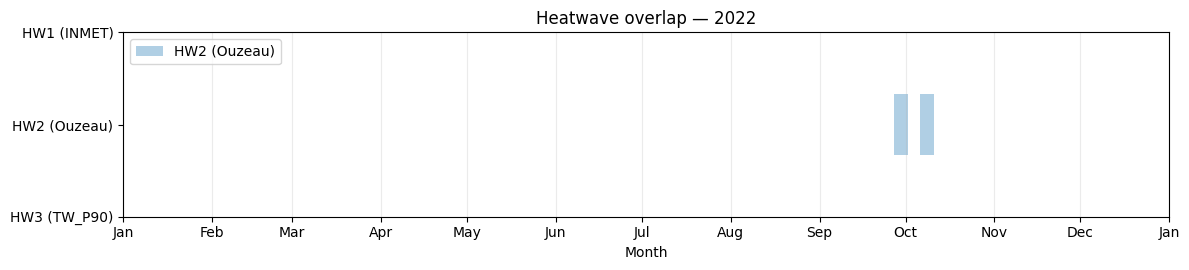

In [29]:
plot_hw_overlap_year(events_all, 2022, methods=("INMET","Ouzeau","TW_P90"),
                     method_labels={"INMET":"HW1 (INMET)", "Ouzeau":"HW2 (Ouzeau)", "TW_P90":"HW3 (TW_P90)"})


In [30]:
def plot_hw_overlap_multi_year(
    events_all: pd.DataFrame,
    years,
    methods=("INMET","Ouzeau","TW_P90"),
    ylabels=("HW1","HW2","HW3"),
    method_to_row=None,
    ncols=3,
    figsize_per_panel=(4.2, 1.6),
    show_no_events_text=True,
    method_colors=None,
):
    ev = events_all.copy()
    ev["start"] = pd.to_datetime(ev["start"])
    ev["end"]   = pd.to_datetime(ev["end"])

    years = list(years)
    n = len(years)
    nrows = math.ceil(n / ncols)

    # cores padrão (paper-friendly)
    if method_colors is None:
        method_colors = {
            "INMET":  "#C44E52",  # vermelho
            "Ouzeau": "#DD8452",  # laranja
            "TW_P90": "#4C72B0",  # azul
        }

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(figsize_per_panel[0]*ncols, figsize_per_panel[1]*nrows),
        sharex=False, sharey=False
    )
    axes = axes.flatten()

    # mapeamento método -> posição vertical
    if method_to_row is None:
        # topo → HW1 → INMET | meio → HW2 → Ouzeau | base → HW3 → TW
        method_to_row = {methods[0]: 2, methods[1]: 1, methods[2]: 0}

    row_h = 8
    gap = 4
    ybase = {0: 0, 1: row_h + gap, 2: 2 * (row_h + gap)}

    for ax, year in zip(axes, years):
        y0 = pd.Timestamp(f"{year}-01-01")
        y1 = pd.Timestamp(f"{year+1}-01-01")

        suby = ev[(ev["end"] >= y0) & (ev["start"] < y1)].copy()

        # configuração fixa do painel
        ax.set_xlim(mdates.date2num(y0), mdates.date2num(y1))
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,7,10,1]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
        ax.grid(True, axis="x", alpha=0.18)
        ax.set_title(str(year), fontsize=10)

        ax.set_yticks([
            ybase[2] + row_h/2,
            ybase[1] + row_h/2,
            ybase[0] + row_h/2
        ])
        ax.set_yticklabels(ylabels, fontsize=8)
        ax.set_ylim(-1, ybase[2] + row_h + 1)

        if suby.empty:
            if show_no_events_text:
                ax.text(0.5, 0.5, "no events",
                        ha="center", va="center",
                        transform=ax.transAxes,
                        fontsize=8, alpha=0.5)
            continue

        # clip no ano
        suby["s"] = suby["start"].clip(lower=y0)
        suby["e"] = suby["end"].clip(upper=y1 - pd.Timedelta(seconds=1))

        # barras por método
        for m in methods:
            subm = suby[suby["method"] == m]
            if subm.empty:
                continue

            bars = []
            for _, r in subm.iterrows():
                left = mdates.date2num(r["s"])
                right = mdates.date2num(r["e"] + pd.Timedelta(days=1))
                bars.append((left, right - left))

            row = method_to_row[m]
            ax.broken_barh(
                bars,
                (ybase[row], row_h),
                facecolors=method_colors.get(m, "#999999"),
                alpha=0.45,
                edgecolor="none"
            )

    # painéis extras
    for ax in axes[len(years):]:
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

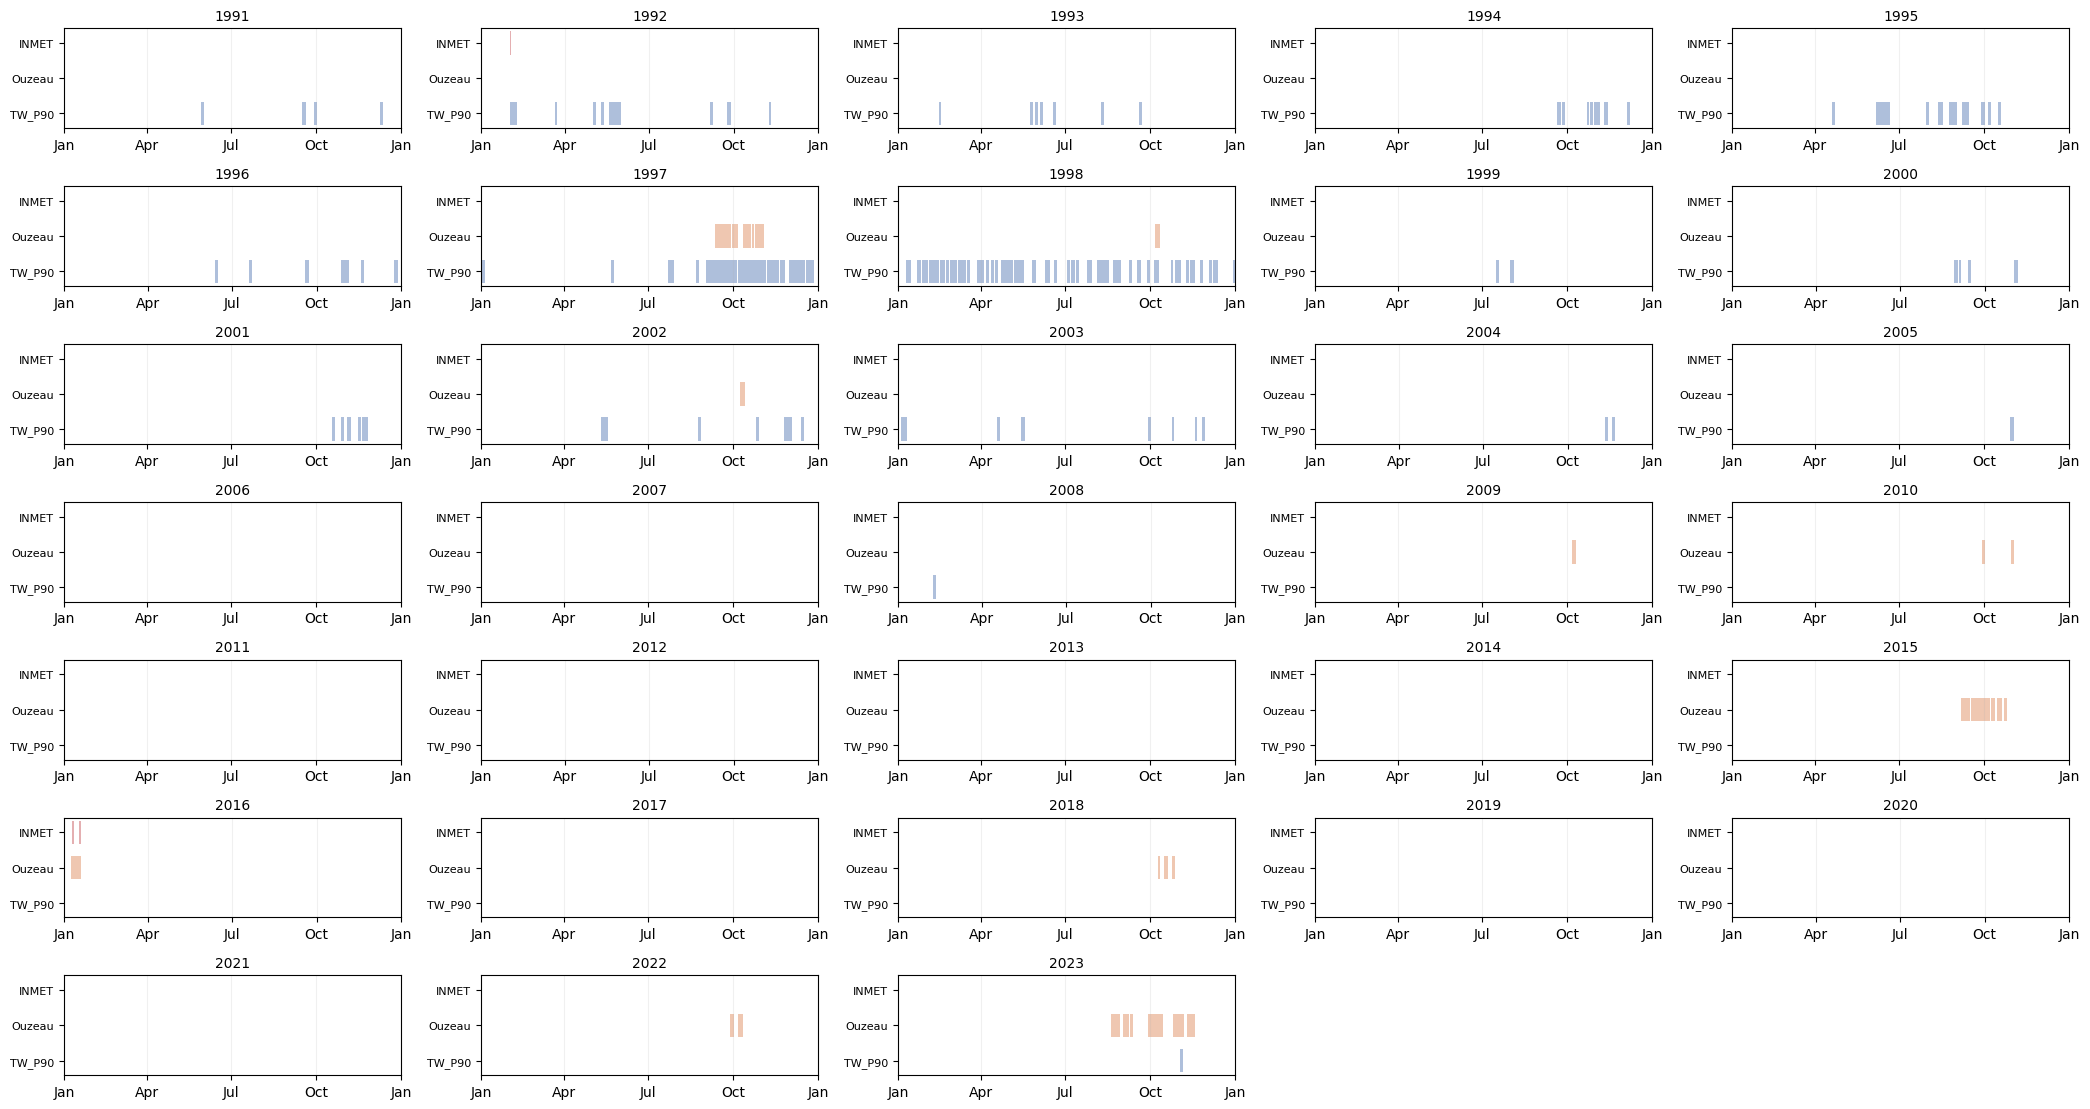

In [31]:
plot_hw_overlap_multi_year(
    events_all,
    years=range(1991, 2024),
    methods=("INMET","Ouzeau","TW_P90"),
    ylabels=("INMET","Ouzeau","TW_P90"),
    ncols=5,
    show_no_events_text=False  # se quiser só “em branco”
)

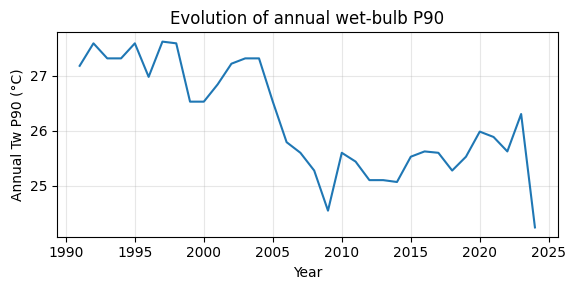

In [32]:
df["year"] = df["timeset"].dt.year

tw_p90_year = (
    df.groupby("year")["tw_c"]
      .quantile(0.90)
      .reset_index(name="tw_p90_year")
)

plt.figure(figsize=(6,3))
plt.plot(tw_p90_year["year"], tw_p90_year["tw_p90_year"])
plt.ylabel("Annual Tw P90 (°C)")
plt.xlabel("Year")
plt.title("Evolution of annual wet-bulb P90")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()